In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import os

In [ ]:
integrate = pd.read_csv("../data/integrate.csv")
integrate.head(2)

,A,B
0,Q9H2S6,Q9NPE6
1,Q9H2S6,Q9BXK5


In [3]:
all_genes = list(set(integrate['A'].tolist()+integrate['B'].tolist()))
len(all_genes)

15939

In [47]:
'P49450' in all_genes

True

In [ ]:
SAVE_ROOT = 'home/lyz/PhaSepGAT/saves/INTEGRATE_ProSE80d_pos1neg1/'
preds = pd.read_pickle(f'{SAVE_ROOT}preds.pkl')
genes = pd.read_pickle(f'{SAVE_ROOT}genes.pkl')

In [5]:
genename_to_uniprot = pd.read_pickle("../data/HUMAN_9606_idmapping_genename.pkl")
genename_to_uniprot_integrate = genename_to_uniprot.set_index(['Uniprot']).loc[list(set(genes)&set(genename_to_uniprot['Uniprot'].tolist())),:].reset_index()

genename_to_uniprot_dict = genename_to_uniprot_integrate.set_index(['ID']).to_dict()['Uniprot']
uniprot_to_genename_dict = genename_to_uniprot_integrate.set_index(['Uniprot']).to_dict()['ID']

In [6]:
llps_scores = pd.read_pickle("../data/HUMAN_9606_PhaSePred_SaPS_PdPS.pkl")
llps_dict = llps_scores.set_index(['entry']).to_dict()

In [7]:
import json

In [9]:
#with open("../data/cophase_data.json",'w') as f:
#    json.dump(co_phase_data_dict,fp=f)

In [52]:
with open("../data/cophase_data.json",'r') as f:
    co_phase_data_dict = json.load(f)

## Deleting existed PPIs in Integreted Human PPI Network

In [69]:
data_files = os.listdir("./promixity")
len(data_files)

220

In [70]:
all_summary = []

In [71]:
for k in tqdm(range(len(data_files))):
    f = data_files[k]
    data = pd.read_csv(f"./promixity/{f}")
    
    bait = data.loc[0,'Bait_uniprot']
    bait_g = data.loc[0,'Bait Gene']
    
    if bait in all_genes:
        preys = data['Prey_uniprot'].tolist()
        preys_in_net = list(set(preys)&set(integrate['A'].tolist()+integrate['B'].tolist()))

        edges_integrate = pd.concat([integrate[integrate['A']==bait], integrate[integrate['B']==bait]])
        edges_partners = list(set(edges_integrate['A'].tolist()) | set(edges_integrate['B'].tolist()))

        partners_not_in_net = [i for i in preys_in_net if i not in edges_partners]
        partners_not_in_net = [i for i in partners_not_in_net if i != bait]

        data_filtered = pd.DataFrame(index=range(len(partners_not_in_net)))
        data_filtered['Bait Gene'] = [bait_g]*len(data_filtered)
        data_filtered['Bait_uniprot'] = [bait]*len(data_filtered)
        data_filtered['Prey_uniprot'] = partners_not_in_net
        data_filtered['article'] = [f[:-4].split('_')[0]]*len(data_filtered)
        data_filtered['Prey Gene'] = data_filtered['Prey_uniprot'].map(uniprot_to_genename_dict)
        data_filtered['Bait_SaPS-10fea'] = data_filtered['Bait_uniprot'].map(llps_dict['SaPS-10fea'])
        data_filtered['Bait_PdPS-10fea'] = data_filtered['Bait_uniprot'].map(llps_dict['PdPS-10fea'])
        data_filtered['Prey_SaPS-10fea'] = data_filtered['Prey_uniprot'].map(llps_dict['SaPS-10fea'])
        data_filtered['Prey_PdPS-10fea'] = data_filtered['Prey_uniprot'].map(llps_dict['PdPS-10fea'])
        
        data_filtered = data_filtered.dropna(subset=['Prey_SaPS-10fea'])

        cossim_list = []
        for p in partners_not_in_net:
            try:
                cossim_list.append(co_phase_data_dict[bait+p])
            except:
                cossim_list.append(co_phase_data_dict[p+bait])
        data_filtered['cos.sim'] = cossim_list

        data_filtered.to_csv(f'./promixity_filtered/{f}',index=False)
        if bait == 'Q01130':
            print(k)
        all_summary.append([bait_g, bait, len(preys),len(preys_in_net),len(partners_not_in_net),f[:-4].split('_')[0]])

100%|██████████| 220/220 [00:34<00:00,  6.45it/s]

219


In [72]:
all_summary = pd.DataFrame(all_summary,columns=['Gene','Uniprot','Preys','Preys in net','Preys not in edges','PMID'])

In [73]:
all_summary[all_summary['Uniprot']=='Q01130']

,Gene,Uniprot,Preys,Preys in net,Preys not in edges,PMID
215,SC35,Q01130,2527,2520,2497,32609799


In [75]:
all_summary['Bait_SaPS-10fea'] = all_summary['Uniprot'].map(llps_dict['SaPS-10fea'])
all_summary['Bait_PdPS-10fea'] = all_summary['Uniprot'].map(llps_dict['PdPS-10fea'])

In [76]:
all_summary.to_csv("promixity_summary_all.csv",index=False)

## For one protein, comparing with background

In [2]:
llps_proteins_list = ['Q01130','Q13283']
unllps_proteins_list = ['P49450','P22001']

In [12]:
backgrounds_all = pd.DataFrame()
real_all =[]

In [13]:
for p in llps_proteins_list:
    background_distribution1 = pd.read_csv(f"./background/{p}.csv")
    real_values1 = pd.read_csv(f"./promixity_combined/{p}.csv")

    background_distribution1 = background_distribution1.loc[:,['mean_cossim']]
    background_distribution1['class'] = [p]*len(background_distribution1)
    backgrounds_all = pd.concat([backgrounds_all,background_distribution1])
    real_all.append(np.mean(real_values1['cos.sim'].tolist()))

for p in unllps_proteins_list:
    background_distribution1 = pd.read_csv(f"./background/{p}.csv")
    real_values1 = pd.read_csv(f"./promixity_combined/{p}.csv")

    background_distribution1 = background_distribution1.loc[:,['mean_cossim']]
    background_distribution1['class'] = [p]*len(background_distribution1)
    backgrounds_all = pd.concat([backgrounds_all,background_distribution1])
    real_all.append(np.mean(real_values1['cos.sim'].tolist()))


In [14]:
backgrounds_all

,mean_cossim,class
0,0.410920,Q01130
1,0.410968,Q01130
2,0.412679,Q01130
3,0.413910,Q01130
4,0.417487,Q01130
...,...,...
995,0.107589,P22001
996,0.116170,P22001
997,0.112703,P22001
998,0.111204,P22001


In [8]:
import matplotlib.pyplot as plt  
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

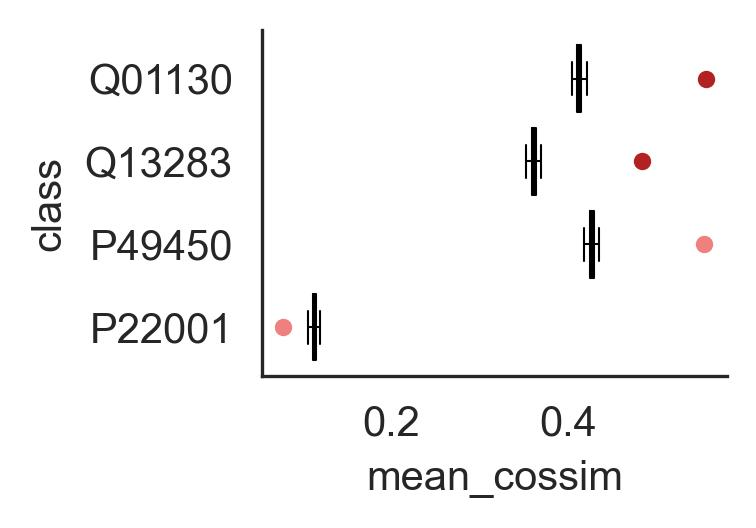

In [15]:
fig = plt.subplots(figsize=(2,1.5),dpi=300) 
sns.set_style('white')


sns.boxplot(data=backgrounds_all,x='mean_cossim',y='class',showfliers=False,color='black',fill=False,linewidth=0.5)

for i in range(2):
    plt.scatter(y=i,x=real_all[i],s=10,color='firebrick')

for i in range(2,4):
    plt.scatter(y=i,x=real_all[i],s=10,color='lightcoral')

sns.despine()

plt.savefig(f"./Fig4B_new.png",bbox_inches = 'tight')
plt.savefig(f"./Fig4B_new.svg",bbox_inches = 'tight',format='svg')

## Comparing cisine similarity with random background

In [98]:
data_files = os.listdir("./promixity_filtered")
len(data_files)

216

In [99]:
data_files[0]

'17289661_Q9NZI8.csv'

In [79]:
import random
import scipy.stats as stats

In [80]:
for k in tqdm(range(len(data_files))):
    f = data_files[k]
    data = pd.read_csv(f"./promixity_filtered/{f}")
    
    
    bait = data.loc[0,'Bait_uniprot']
    bait_g = data.loc[0,'Bait Gene']
    bait_saps = data.loc[0,'Bait_SaPS-10fea']
    bait_pdps = data.loc[0,'Bait_PdPS-10fea']
    
    bait_data = [i for i in list(co_phase_data_dict.keys()) if bait in i]
    bait_cossim = [co_phase_data_dict[i] for i in bait_data]
    bait_with_cossim = pd.DataFrame(index=range(len(bait_data)))
    bait_with_cossim['Prey_uniprot'] = bait_data
    bait_with_cossim['cossim'] = bait_cossim
    bait_with_cossim.to_csv(f"./all_partners_cossim/{bait}.csv")
    

100%|██████████| 216/216 [25:50<00:00,  7.18s/it]


In [ ]:
# 合并相同蛋白

In [82]:
len(os.listdir(f"./all_partners_cossim/"))

203

In [140]:
all_uniprot = []
for i in data_files:
    all_uniprot.append(i[1:].split('.')[0].split('_')[1])
all_uniprot = np.unique(all_uniprot).tolist()
len(all_uniprot)

370

In [141]:
data_summary = []

In [142]:
for p in tqdm(all_uniprot):
    this_p_file = [i for i in data_files if p in i]
    
    pmid = ''
    
    this_p_data_all = pd.DataFrame()
    for pf in this_p_file:
        #data_pf = pd.read_csv('./promixity_filtered/'+pf)
        data_pf = pd.read_csv(pf)
        this_p_data_all = pd.concat([this_p_data_all,data_pf])
        pmid+=pf.split('/')[2].split('_')[0]+', '
        #pmid+=pf.split('_')[0]+', '
        
    this_p_data_all = this_p_data_all.drop_duplicates(subset=['Prey_uniprot'])
    this_p_data_all.to_csv(f"./promixity_combined/{p}.csv")
    
    data_summary.append([p,len(this_p_data_all),pmid[:-2]])

100%|██████████| 370/370 [00:46<00:00,  7.98it/s]


In [113]:
data_summary_df = pd.DataFrame(data_summary,columns = ['uniprot','Num_preys','PMID'])
data_summary_df['SaPS-10fea'] = data_summary_df['uniprot'].map(llps_dict['SaPS-10fea'])
data_summary_df['PdPS-10fea'] = data_summary_df['uniprot'].map(llps_dict['PdPS-10fea'])
data_summary_df['SaPS-8fea'] = data_summary_df['uniprot'].map(llps_dict['SaPS-8fea'])
data_summary_df['PdPS-8fea'] = data_summary_df['uniprot'].map(llps_dict['PdPS-8fea'])

In [114]:
data_summary_df

,uniprot,Num_preys,PMID,SaPS-10fea,PdPS-10fea,SaPS-8fea,PdPS-8fea
0,A0AV96,146,29395067,0.329001,0.257143,0.335920,0.367314
1,A0FGR8,149,37931956,0.421148,0.709921,0.075430,0.336415
2,A5YKK6,8,29395067,0.167426,0.152646,0.536207,0.404258
3,O00178,26,29395067,0.713772,0.446460,0.269502,0.484926
4,O00244,49,34550632,0.173481,0.399118,0.072456,0.433647
...,...,...,...,...,...,...,...
198,Q9Y3F4,7,29395067,0.288940,0.477604,0.062340,0.162144
199,Q9Y4F3,51,29395067,0.109177,0.290736,0.161058,0.574381
200,Q9Y4Z0,52,29395067,0.093078,0.261316,0.560568,0.396553
201,Q9Y5A9,125,29395067,0.942175,0.901862,0.938018,0.812827


In [116]:
data_summary_df.to_csv("Proximity_combined.csv",index=None)

In [115]:
len(os.listdir(f"./promixity_combined/"))

203

In [120]:
data_files = os.listdir(f"./promixity_combined/")

In [121]:
all_bait_compare_summary = []

In [122]:
for k in tqdm(range(len(data_files))):
    f = data_files[k]
    data = pd.read_csv(f"./promixity_combined/{f}")

    data = data.drop_duplicates(subset=['Prey_uniprot'])
    
    bait = data.loc[0,'Bait_uniprot']
    bait_g = data.loc[0,'Bait Gene']
    bait_saps = data.loc[0,'Bait_SaPS-10fea']
    bait_pdps = data.loc[0,'Bait_PdPS-10fea']
    #articles = ','.join([str(i) for i in data.drop_duplicates(subset=['article'])['article'].tolist()])
    
    cossim = data['cos.sim'].tolist()

    bait_with_cossim = pd.read_csv(f"./all_partners_cossim/{bait}.csv")
    
    
    
    background_list = []
    for m in range(1000):
        random_background = bait_with_cossim.sample(n=len(data),random_state=m)
        random_cossim = random_background['cossim'].tolist()
        pv = stats.mannwhitneyu(cossim,random_cossim,alternative='greater')[1]
        mean_cossim = np.mean(random_cossim)
        background_list.append([','.join(random_background['Prey_uniprot'].tolist()),','.join([str(i) for i in random_cossim]),mean_cossim,pv])
    
    background_df = pd.DataFrame(background_list,columns=['protein_list','cos.sim','mean_cossim','pv'])
    background_df.to_csv(f"./background/{bait}.csv")
    
    zscore = (np.mean(cossim)-np.mean(background_df['mean_cossim'].tolist()))/np.std(background_df['mean_cossim'].tolist())
    
    all_bait_compare_summary.append([bait,bait_g,bait_saps,bait_pdps,len(data),np.mean(background_df['pv'].tolist()),zscore])


100%|██████████| 203/203 [31:30<00:00,  9.31s/it]


In [123]:
pmid_df = []

In [124]:
for k in tqdm(range(len(data_files))):
    f = data_files[k]
    data = pd.read_csv(f"./promixity_combined/{f}")
    data = data.drop_duplicates(subset=['Prey_uniprot'])
    
    bait = data.loc[0,'Bait_uniprot']
    bait_g = data.loc[0,'Bait Gene']
    bait_saps = data.loc[0,'Bait_SaPS-10fea']
    bait_pdps = data.loc[0,'Bait_PdPS-10fea']
    pmids = ', '.join([str(i) for i in data.drop_duplicates(subset=['article'],keep='first')['article'].tolist()])
    


    pmid_df.append([bait,bait_g,bait_saps,pmids])


100%|██████████| 203/203 [00:00<00:00, 353.18it/s]


In [125]:
pmid_df = pd.DataFrame(pmid_df,columns=['Gene','Uniprot','SaPS','article'])

In [126]:
pmid_df.to_csv("tmp.csv")

In [127]:
all_bait_compare_summary_df = pd.DataFrame(all_bait_compare_summary,columns=['Gene','Uniprot','SaPS','PdPS','num_Preys','mean_pv','zscore'])

In [128]:
all_bait_compare_summary_df = all_bait_compare_summary_df.drop_duplicates(subset=['Gene'])

In [129]:
all_bait_compare_summary_df

,Gene,Uniprot,SaPS,PdPS,num_Preys,mean_pv,zscore
0,Q9NZI8,IMP1,0.525629,0.795508,113,8.214131e-22,18.011417
1,Q9NX05,FAM120C,0.231581,0.102665,225,6.738799e-16,14.064514
2,P60842,eIF4A1,0.163013,0.365248,58,2.504988e-08,9.527152
3,Q9H074,PAIP1,0.605274,0.589198,28,2.910619e-04,6.222006
4,Q9H7E2,TDRD3,0.897540,0.883250,135,3.364009e-18,14.750538
...,...,...,...,...,...,...,...
198,Q6TCH7,PAQR3,0.085218,0.067076,988,9.486375e-01,-3.963986
199,Q13283,G3BP1,0.929826,0.575079,2353,1.021667e-97,34.470688
200,P01116,KRAS,0.583972,0.842191,1549,2.560274e-61,25.772949
201,Q8N884,cGAS,0.657121,0.932160,15,1.163667e-02,3.846812


In [130]:
all_bait_compare_summary_df[all_bait_compare_summary_df['Uniprot']=='SC35']

,Gene,Uniprot,SaPS,PdPS,num_Preys,mean_pv,zscore
189,Q01130,SC35,0.906741,0.957755,2497,4.682668e-162,43.563056


In [135]:
filelist = os.listdir("./promixity_combined")

In [136]:
len(filelist)

203

In [133]:
all_interactom = pd.DataFrame()

In [137]:
for f in filelist:
    data = pd.read_csv(f"./promixity_combined/{f}")
    all_interactom = pd.concat([all_interactom,data])

In [138]:
all_interactom.to_csv("./all_promixity_data_combined.csv")

In [131]:
all_bait_compare_summary_df[all_bait_compare_summary_df['Uniprot']=='SC35']

,Gene,Uniprot,SaPS,PdPS,num_Preys,mean_pv,zscore
189,Q01130,SC35,0.906741,0.957755,2497,4.682668e-162,43.563056


In [132]:
all_bait_compare_summary_df.to_csv("./pv_zscore_filtered.csv",index=False)

In [13]:
all_bait_compare_summary_df = pd.read_csv("./pv_zscore_filtered.csv")
all_bait_compare_summary_df.head(1)

,Gene,Uniprot,SaPS,PdPS,num_Preys,mean_pv,zscore,article
0,Q9NZI8,IMP1,0.525629,0.795508,113,8.210000e-22,18.011417,"17289661, 29395067"


In [14]:
len(all_bait_compare_summary_df)

203

In [145]:
all_ar = []
for i in all_bait_compare_summary_df['article'].tolist():
    all_ar += i.split(', ')
len(np.unique(all_ar))

62

In [15]:
all_bait_compare_summary_df = all_bait_compare_summary_df[all_bait_compare_summary_df['num_Preys']>=50]
len(all_bait_compare_summary_df)

149

In [16]:
all_bait_compare_summary_df

,Gene,Uniprot,SaPS,PdPS,num_Preys,mean_pv,zscore,article
0,Q9NZI8,IMP1,0.525629,0.795508,113,8.210000e-22,18.011417,"17289661, 29395067"
1,Q9NX05,FAM120C,0.231581,0.102665,225,6.740000e-16,14.064514,29395067
2,P60842,eIF4A1,0.163013,0.365248,58,2.500000e-08,9.527152,"31442426, 29395067"
4,Q9H7E2,TDRD3,0.897540,0.883250,135,3.360000e-18,14.750538,29395067
5,Q9HCE1,MOV10,0.096921,0.313998,129,5.590000e-19,15.361266,29395067
...,...,...,...,...,...,...,...,...
197,P00533,EGFR,0.752162,0.866251,1761,4.258136e-02,2.297141,35705039
198,Q6TCH7,PAQR3,0.085218,0.067076,988,9.486375e-01,-3.963986,30466064
199,Q13283,G3BP1,0.929826,0.575079,2353,1.020000e-97,34.470688,"29395067, 29373831, 33217318, 37119817"
200,P01116,KRAS,0.583972,0.842191,1549,2.560000e-61,25.772949,"38453365, 30639242"


In [148]:
all_bait_compare_summary_df[all_bait_compare_summary_df['mean_pv']>0.05]

,Gene,Uniprot,SaPS,PdPS,num_Preys,mean_pv,zscore,article
81,Q9BPZ3,PAIP2,0.212680,0.540822,59,0.090310,2.108847,29395067
159,Q9NX09,DDIT4,0.118733,0.059997,104,0.501532,0.520415,35563580
161,P28328,PEX2,0.096385,0.061623,230,0.455296,-0.916685,35523862
179,Q15262,PTPRK,0.113755,0.224419,72,0.390954,0.182922,30924770
192,P22001,Kv1.3,0.135757,0.101213,1769,1.000000,-14.125915,38936775
198,Q6TCH7,PAQR3,0.085218,0.067076,988,0.948637,-3.963986,30466064


In [149]:
all_ar = []
for i in all_bait_compare_summary_df['article'].tolist():
    all_ar += i.split(', ')

In [150]:
len(np.unique(all_ar))

55

In [62]:
all_bait_compare_summary_df['class_self'] = ['SaPS' if i > 0.5 else 'notSaPS' for i in all_bait_compare_summary_df['SaPS'].tolist()]
all_bait_compare_summary_df['class_other'] = ['PdPS' if i > 0.5 else 'notPdPS' for i in all_bait_compare_summary_df['PdPS'].tolist()]
all_bait_compare_summary_df['class_all'] = ['LLPS' if all_bait_compare_summary_df['PdPS'].tolist()[i] > 0.5 or all_bait_compare_summary_df['SaPS'].tolist()[i] > 0.5 else 'notLLPS' for i in range(len(all_bait_compare_summary_df))]

In [63]:
all_bait_compare_summary_df

,Gene,Uniprot,SaPS,PdPS,num_Preys,mean_pv,zscore,article,class_self,class_other,class_all,-log10(pv)
0,Q9NZI8,IMP1,0.525629,0.795508,113,8.210000e-22,18.011417,"17289661, 29395067",SaPS,PdPS,LLPS,21.085657
1,Q9NX05,FAM120C,0.231581,0.102665,225,6.740000e-16,14.064514,29395067,notSaPS,notPdPS,notLLPS,15.171340
2,P60842,eIF4A1,0.163013,0.365248,58,2.500000e-08,9.527152,"31442426, 29395067",notSaPS,notPdPS,notLLPS,7.602060
4,Q9H7E2,TDRD3,0.897540,0.883250,135,3.360000e-18,14.750538,29395067,SaPS,PdPS,LLPS,17.473661
5,Q9HCE1,MOV10,0.096921,0.313998,129,5.590000e-19,15.361266,29395067,notSaPS,notPdPS,notLLPS,18.252588
...,...,...,...,...,...,...,...,...,...,...,...,...
197,P00533,EGFR,0.752162,0.866251,1761,4.258136e-02,2.297141,35705039,SaPS,PdPS,LLPS,1.370780
198,Q6TCH7,PAQR3,0.085218,0.067076,988,9.486375e-01,-3.963986,30466064,notSaPS,notPdPS,notLLPS,0.022900
199,Q13283,G3BP1,0.929826,0.575079,2353,1.020000e-97,34.470688,"29395067, 29373831, 33217318, 37119817",SaPS,PdPS,LLPS,96.991400
200,P01116,KRAS,0.583972,0.842191,1549,2.560000e-61,25.772949,"38453365, 30639242",SaPS,PdPS,LLPS,60.591760


In [19]:
all_bait_compare_summary_df['-log10(pv)'] = -np.log10(all_bait_compare_summary_df['mean_pv'].tolist())

In [20]:
len(all_bait_compare_summary_df[all_bait_compare_summary_df['class_self']=='SaPS'])/len(all_bait_compare_summary_df)

0.5704697986577181

In [22]:
import scipy.stats as stats

In [23]:
stats.spearmanr(all_bait_compare_summary_df['SaPS'].tolist(),all_bait_compare_summary_df['-log10(pv)'].tolist())

SignificanceResult(statistic=0.2782117524141834, pvalue=0.0005914839246766989)

In [26]:
stats.spearmanr(all_bait_compare_summary_df['SaPS'].tolist(),all_bait_compare_summary_df['zscore'].tolist())

SignificanceResult(statistic=0.2750916016687829, pvalue=0.0006853002669782068)

In [24]:
stats.spearmanr(all_bait_compare_summary_df['PdPS'].tolist(),all_bait_compare_summary_df['-log10(pv)'].tolist())

SignificanceResult(statistic=0.27538933011922273, pvalue=0.0006757905016461017)

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

In [74]:
len(all_bait_compare_summary_df[all_bait_compare_summary_df['class_self']=='SaPS'])

85

In [75]:
len(all_bait_compare_summary_df[all_bait_compare_summary_df['class_self']=='notSaPS'])

64

C:\Users\wqswx\AppData\Local\Temp\ipykernel_15432\236903338.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(all_bait_compare_summary_df[all_bait_compare_summary_df['class_all']=='LLPS']['zscore'].tolist(),shade=True,color='steelblue')
C:\Users\wqswx\AppData\Local\Temp\ipykernel_15432\236903338.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(all_bait_compare_summary_df[all_bait_compare_summary_df['class_all']!='LLPS']['zscore'].tolist(),shade=True,color='lightgrey')


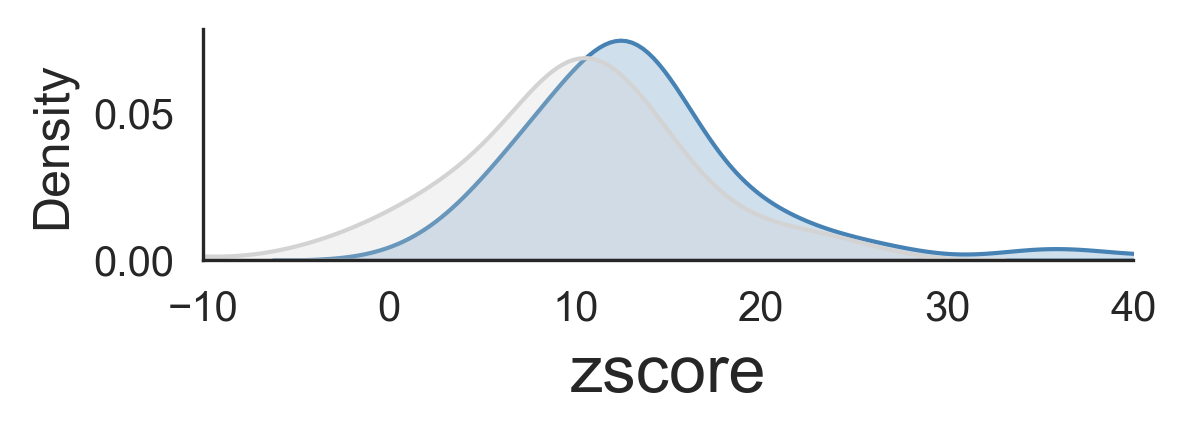

In [72]:
fig = plt.subplots(figsize=(4,1),dpi=300) 
sns.set_style('white')

sns.kdeplot(all_bait_compare_summary_df[all_bait_compare_summary_df['class_all']=='LLPS']['zscore'].tolist(),shade=True,color='steelblue')
sns.kdeplot(all_bait_compare_summary_df[all_bait_compare_summary_df['class_all']!='LLPS']['zscore'].tolist(),shade=True,color='lightgrey')

plt.xlabel('zscore',fontsize=16)
plt.ylabel('Density',fontsize=12)
plt.xlim([-10,40])

sns.despine()

C:\Users\wqswx\AppData\Local\Temp\ipykernel_14888\42482368.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(all_bait_compare_summary_df,x='zscore', y='class_self', palette={'SaPS':'steelblue','notSaPS':'grey'},showfliers=False,fill=False)


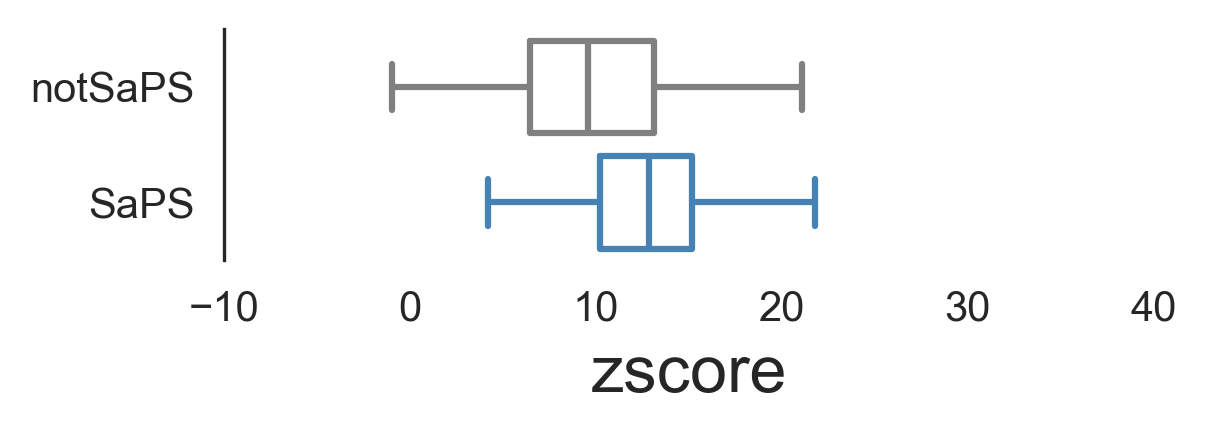

In [60]:
fig, ax = plt.subplots(figsize=(4,1),dpi=300)

sns.boxplot(all_bait_compare_summary_df,x='zscore', y='class_self', palette={'SaPS':'steelblue','notSaPS':'grey'},showfliers=False,fill=False)
plt.xlabel('zscore',fontsize=16)
plt.ylabel('',fontsize=12)

sns.despine(bottom=True)

plt.xlim([-10,40])



In [55]:
stats.mannwhitneyu(all_bait_compare_summary_df[all_bait_compare_summary_df['class_self']=='SaPS']['zscore'].tolist(),all_bait_compare_summary_df[all_bait_compare_summary_df['class_self']=='notSaPS']['zscore'])

MannwhitneyuResult(statistic=3656.0, pvalue=0.00014897561086417603)

In [73]:
stats.mannwhitneyu(all_bait_compare_summary_df[all_bait_compare_summary_df['class_all']=='LLPS']['zscore'].tolist(),all_bait_compare_summary_df[all_bait_compare_summary_df['class_all']!='LLPS']['zscore'])

MannwhitneyuResult(statistic=3251.0, pvalue=0.0026418594375993924)

In [56]:
stats.mannwhitneyu(all_bait_compare_summary_df[all_bait_compare_summary_df['class_self']=='SaPS']['mean_pv'].tolist(),all_bait_compare_summary_df[all_bait_compare_summary_df['class_self']=='notSaPS']['mean_pv'])

MannwhitneyuResult(statistic=1707.0, pvalue=0.00016872890207256857)

In [18]:
all_bait_compare_summary_df

,Gene,Uniprot,SaPS,PdPS,num_Preys,mean_pv,zscore,article,class_self,class_other,class_all
0,Q01130,SC35,0.906741,0.957755,2497,0.000000e+00,69.479853,32609799,SaPS,PdPS,LLPS
1,Q13501,SQSTM1,0.744216,0.938113,1391,1.430000e-140,38.711853,38014048,SaPS,PdPS,LLPS
2,Q15287,RNPS1,0.874299,0.890033,759,1.630000e-96,37.084737,35640609,SaPS,PdPS,LLPS
3,Q92540,SMG7,0.748550,0.680126,266,1.180000e-71,31.956326,29395067,SaPS,PdPS,LLPS
4,Q69YH5,RepoMan,0.908337,0.618734,782,1.020000e-72,30.411836,33134894,SaPS,PdPS,LLPS
...,...,...,...,...,...,...,...,...,...,...,...
196,P28328,PEX2,0.096385,0.061623,230,3.660000e-41,-25.220448,35523862,notSaPS,notPdPS,notLLPS
197,P00533,EGFR,0.752162,0.866251,1761,5.400000e-61,-25.782239,35705039,SaPS,PdPS,LLPS
198,Q92934,BAD,0.883480,0.858208,346,5.460000e-70,-31.190900,38959414,SaPS,PdPS,LLPS
199,Q6TCH7,PAQR3,0.085218,0.067076,988,2.750000e-165,-46.321951,30466064,notSaPS,notPdPS,notLLPS


In [32]:
all_bait_compare_summary_df.loc[0,'-log10(pv)']=1000

In [57]:
all_bait_compare_summary_df[all_bait_compare_summary_df['class_all']=='LLPS'].sort_values(by=['mean_pv'],ascending=True)

,Gene,Uniprot,SaPS,PdPS,num_Preys,mean_pv,zscore,article,class_self,class_other,class_all,-log10(pv)
70,Q01130,SC35,0.906741,0.957755,2497,4.680000e-162,43.563056,32609799,SaPS,PdPS,LLPS,161.329754
93,Q15287,RNPS1,0.874299,0.890033,759,7.590000e-105,35.449129,35640609,SaPS,PdPS,LLPS,104.119758
82,Q13501,SQSTM1,0.744216,0.938113,1391,1.870000e-72,26.874620,38014048,SaPS,PdPS,LLPS,71.728158
31,P01116,KRAS,0.583972,0.842191,1549,2.560000e-61,25.772949,"38453365, 30639242",SaPS,PdPS,LLPS,60.591760
81,Q13283,G3BP1,0.929826,0.575079,753,1.370000e-51,24.402414,"29373831, 37119817, 33217318, 29395067",SaPS,PdPS,LLPS,50.863279
...,...,...,...,...,...,...,...,...,...,...,...,...
13,O60333,KIF1B,0.246605,0.751183,56,1.094165e-03,5.092544,29395067,notSaPS,PdPS,LLPS,2.960917
50,P46937,YAP1,0.944812,0.841596,177,2.469137e-03,4.714279,33472949,SaPS,PdPS,LLPS,2.607455
49,P46531,NOTCH1,0.708261,0.674697,294,1.044383e-02,4.215314,37454291,SaPS,PdPS,LLPS,1.981140
28,P00533,EGFR,0.752162,0.866251,1761,4.258136e-02,2.297141,35705039,SaPS,PdPS,LLPS,1.370780


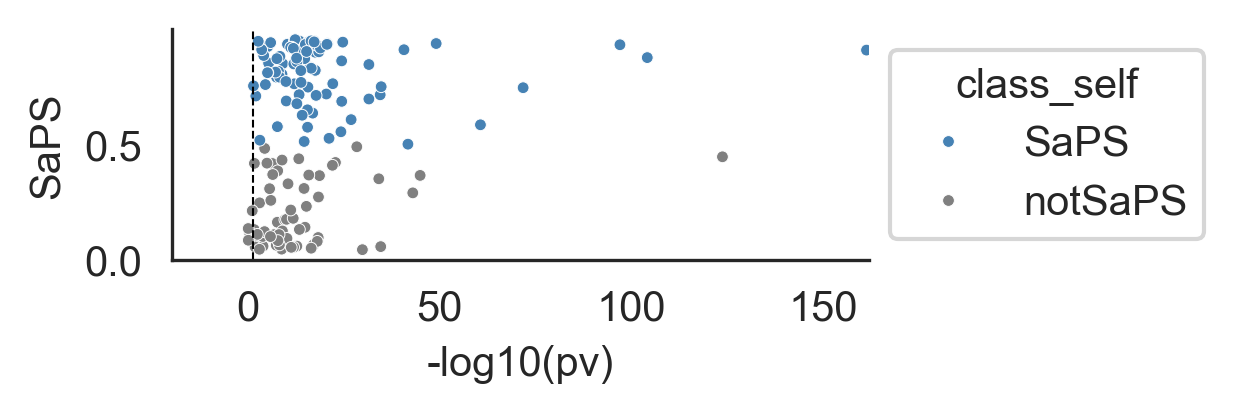

In [106]:
fig, ax = plt.subplots(figsize=(3,1),dpi=300)

sns.scatterplot(data = all_bait_compare_summary_df,y='SaPS',x='-log10(pv)', hue='class_self',palette={'SaPS':'steelblue','notSaPS':'grey'},s=8)

#ax = sns.scatterplot(all_bait_compare_summary_df,y='class_self',y='-log10(pv)', hue='class_self',palette={'SaPS':'steelblue','notSaPS':'lightgrey'},alpha=1,s=10)

plt.axvline(x=-np.log10(0.05), color='black', linestyle='dashed',linewidth=0.5)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()

plt.xlim([-20,162])


C:\Users\wqswx\AppData\Local\Temp\ipykernel_15432\2038012187.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(all_bait_compare_summary_df,y='class_self',x='-log10(pv)', fill=False, palette={'SaPS':'steelblue','notSaPS':'grey'})


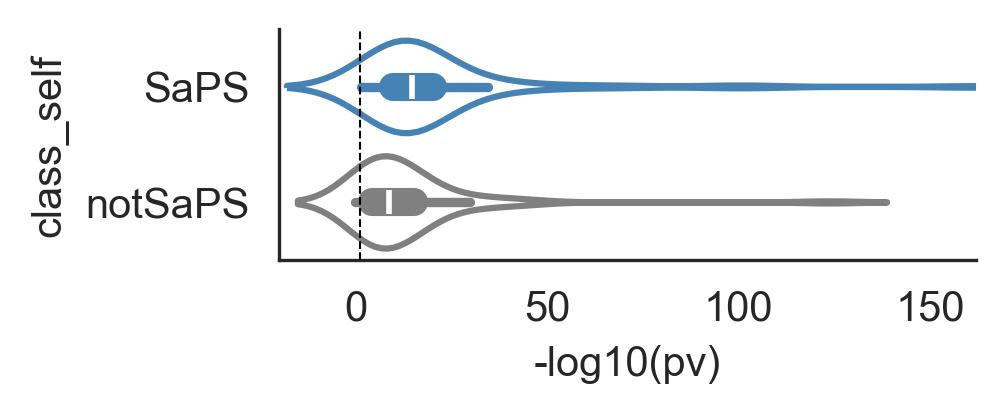

In [105]:
fig, ax = plt.subplots(figsize=(3,1),dpi=300)

sns.violinplot(all_bait_compare_summary_df,y='class_self',x='-log10(pv)', fill=False, palette={'SaPS':'steelblue','notSaPS':'grey'})
#ax = sns.scatterplot(all_bait_compare_summary_df,y='class_self',y='-log10(pv)', hue='class_self',palette={'SaPS':'steelblue','notSaPS':'lightgrey'},alpha=1,s=10)

plt.axvline(x=-np.log10(0.05), color='black', linestyle='dashed',linewidth=0.5)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()

plt.xlim([-20,162])


### Showing of partners

In [61]:
#SC35
data = pd.read_csv(f"./promixity_combined/Q01130.csv")
data.head(1)

,Unnamed: 0,Bait Gene,Bait_uniprot,Prey_uniprot,article,Prey Gene,Bait_SaPS-10fea,Bait_PdPS-10fea,Prey_SaPS-10fea,Prey_PdPS-10fea,cos.sim
0,0,SC35,Q01130,P37837,32609799,TALDO1,0.906741,0.957755,0.246173,0.235115,0.549101


In [62]:
data = data.sort_values(by=['cos.sim'],ascending=False)
data

,Unnamed: 0,Bait Gene,Bait_uniprot,Prey_uniprot,article,Prey Gene,Bait_SaPS-10fea,Bait_PdPS-10fea,Prey_SaPS-10fea,Prey_PdPS-10fea,cos.sim
479,479,SC35,Q01130,Q9UKV3,32609799,ACIN1,0.906741,0.957755,0.904090,0.847837,0.842163
1289,1289,SC35,Q01130,Q9NR30,32609799,DDX21,0.906741,0.957755,0.934394,0.866877,0.832513
787,787,SC35,Q01130,Q9NYF8,32609799,BCLAF1,0.906741,0.957755,0.930382,0.892947,0.832174
463,463,SC35,Q01130,Q5T8P6,32609799,RBM26,0.906741,0.957755,0.802101,0.924976,0.827876
1232,1232,SC35,Q01130,O75152,32609799,ZC3H11A,0.906741,0.957755,0.810979,0.899011,0.827068
...,...,...,...,...,...,...,...,...,...,...,...
1203,1203,SC35,Q01130,Q9H9A6,32609799,LRRC40,0.906741,0.957755,0.066375,0.064865,0.068744
1773,1773,SC35,Q01130,Q56VL3,32609799,OCIAD2,0.906741,0.957755,0.045673,0.037556,0.055287
2127,2127,SC35,Q01130,P01893,32609799,HLA-H,0.906741,0.957755,0.072801,0.031970,0.033507
903,903,SC35,Q01130,P04439,32609799,HLA-A,0.906741,0.957755,0.440503,0.823757,0.033107


In [63]:
data['rank'] = range(len(data))

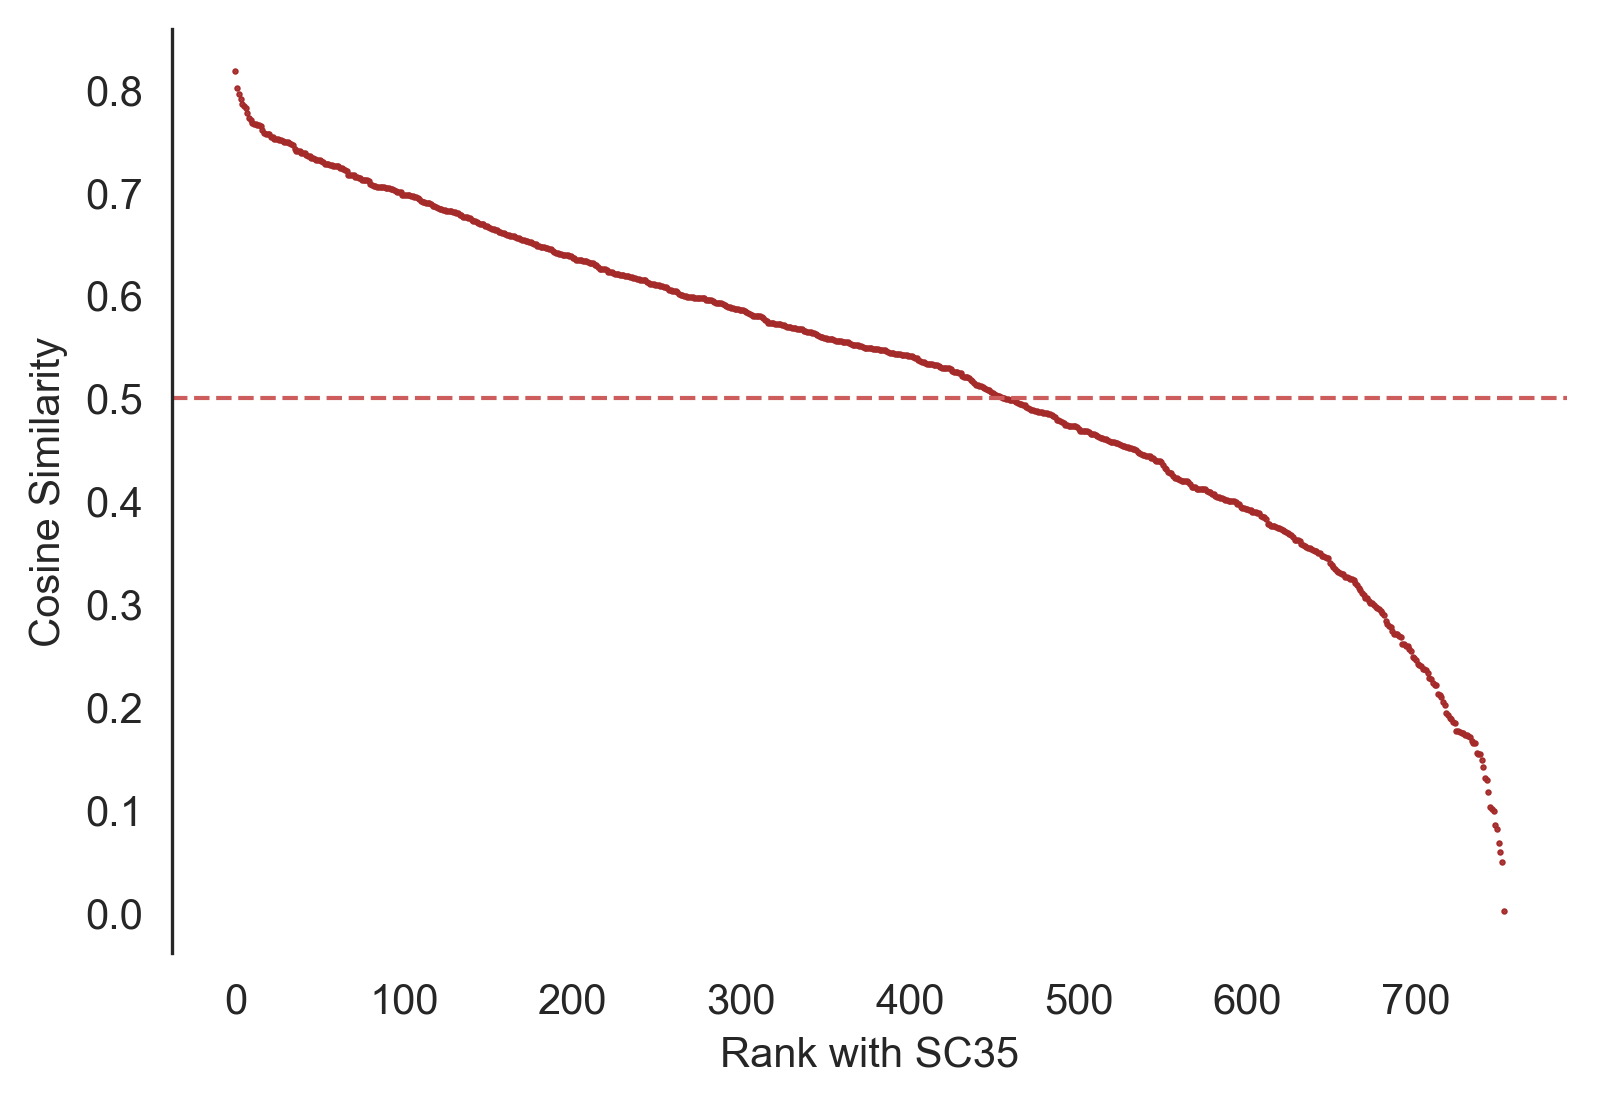

In [253]:
fig, ax = plt.subplots(figsize=(6,4),dpi=300)
plt.scatter(data=data, y="cos.sim", x='rank', color = 'brown',s=0.3)
sns.despine(bottom=True)
plt.axhline(y=0.5,color='indianred',linestyle='--',linewidth=1)
plt.legend().remove()
plt.xlabel('Rank with SC35')
plt.ylabel('Cosine Similarity')


In [66]:
#G3BP1
data = pd.read_csv(f"./promixity_combined/Q13283.csv")
data.head(1)

,Unnamed: 0,Bait Gene,Bait_uniprot,Prey_uniprot,article,Prey Gene,Bait_SaPS-10fea,Bait_PdPS-10fea,Prey_SaPS-10fea,Prey_PdPS-10fea,cos.sim
0,293,G3BP1,Q13283,A0FGR8,29373831,ESYT2,0.929826,0.575079,0.421148,0.709921,0.421509


In [67]:
data = data.sort_values(by=['cos.sim'],ascending=False)
data

,Unnamed: 0,Bait Gene,Bait_uniprot,Prey_uniprot,article,Prey Gene,Bait_SaPS-10fea,Bait_PdPS-10fea,Prey_SaPS-10fea,Prey_PdPS-10fea,cos.sim
370,38,G3BP1,Q13283,Q14157,29395067,UBAP2L,0.929826,0.575079,0.945615,0.953562,0.817712
546,34,G3BP1,Q13283,Q92804,29373831,TAF15,0.929826,0.575079,0.934126,0.906644,0.801722
474,20,G3BP1,Q13283,Q7Z739,29395067,YTHDF3,0.929826,0.575079,0.934216,0.743057,0.795036
550,107,G3BP1,Q13283,Q92945,29373831,KHSRP,0.929826,0.575079,0.950581,0.897286,0.790708
202,71,G3BP1,Q13283,P35637,29373831,FUS,0.929826,0.575079,0.929791,0.911399,0.785952
...,...,...,...,...,...,...,...,...,...,...,...
643,467,G3BP1,Q13283,Q9H9A6,29373831,LRRC40,0.929826,0.575079,0.066375,0.064865,0.080874
128,64,G3BP1,Q13283,P13640,37119817,MT1G,0.929826,0.575079,0.097001,0.123247,0.067636
365,194,G3BP1,Q13283,Q13907,29373831,IDI1,0.929826,0.575079,0.161062,0.547688,0.058325
81,358,G3BP1,Q13283,O95470,29373831,SGPL1,0.929826,0.575079,0.066514,0.236983,0.049441


In [68]:
data['rank'] = range(len(data))

In [69]:
','.join(data.iloc[:20,:]['Prey Gene'].tolist())

'UBAP2L,TAF15,YTHDF3,KHSRP,FUS,KHDRBS1,IGF2BP2,HNRNPR,TDRD3,CDV3,RALY,EIF4H,SAFB,FAM98A,PTBP3,HNRNPD,EWSR1,FUBP1,UPF1,ZC3H7B'

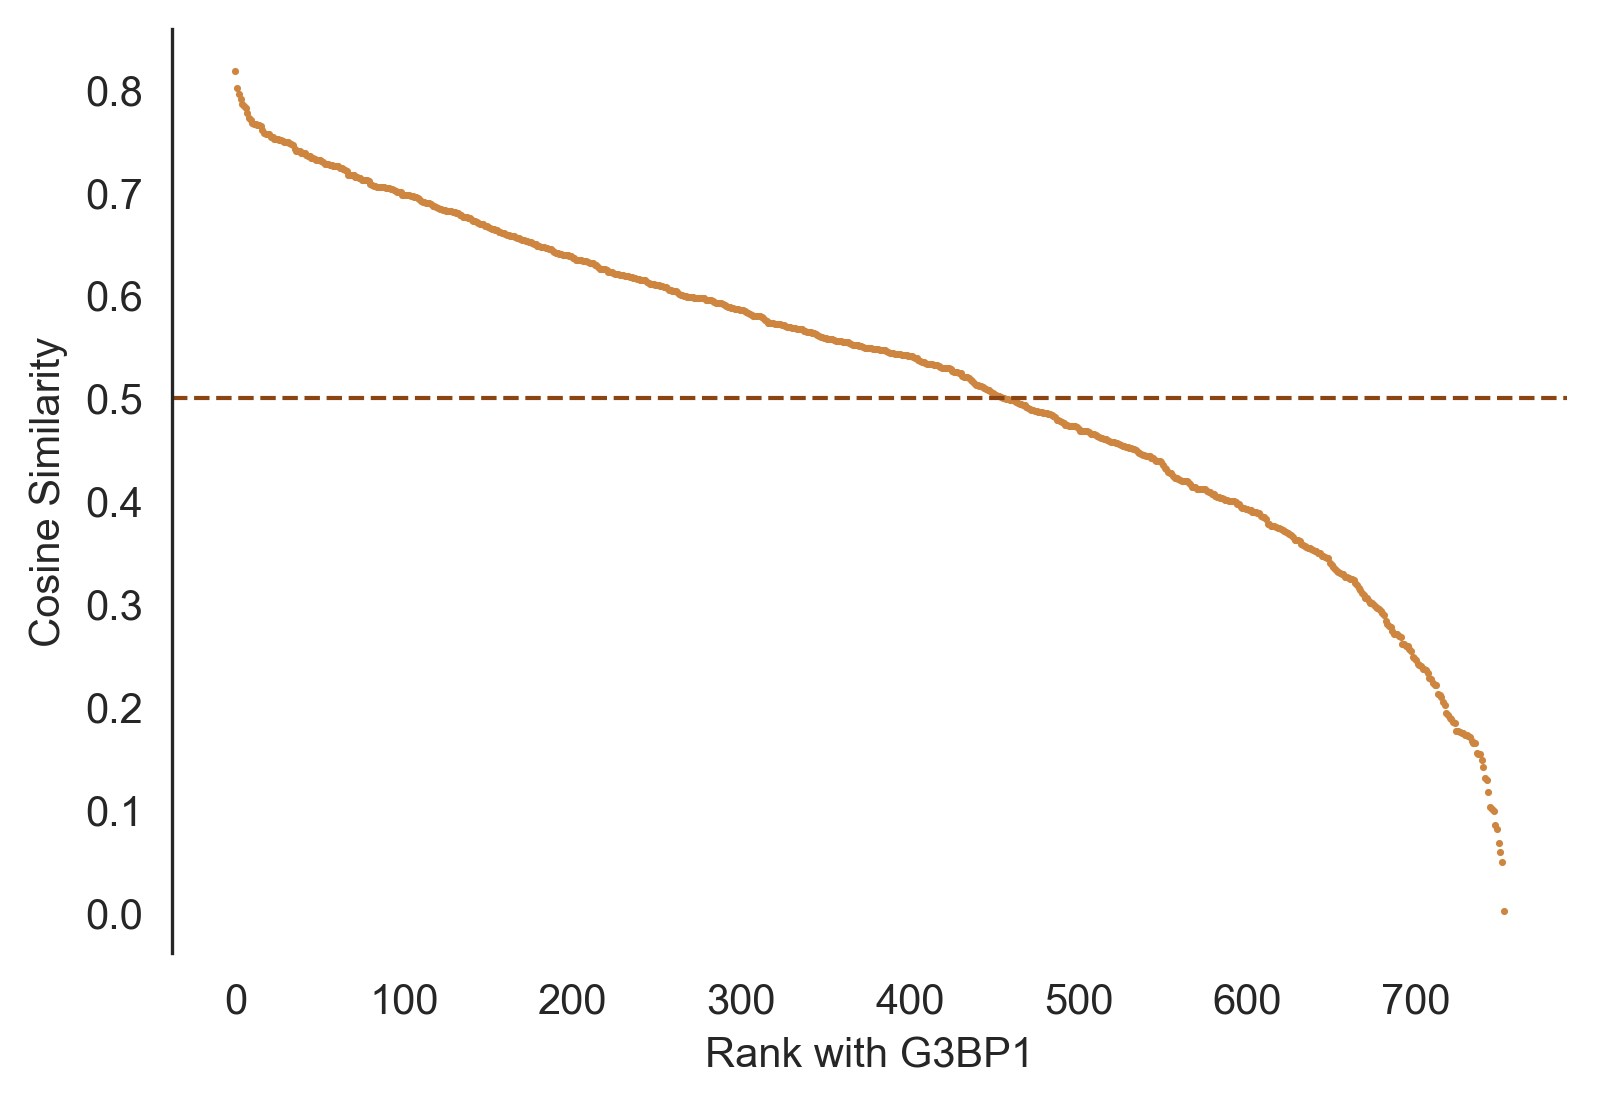

In [257]:
fig, ax = plt.subplots(figsize=(6,4),dpi=300)
plt.scatter(data=data, y="cos.sim", x='rank', color = 'peru',s=0.5)
sns.despine(bottom=True)
plt.axhline(y=0.5,color='saddlebrown',linestyle='--',linewidth=1)
plt.legend().remove()
plt.xlabel('Rank with G3BP1')
plt.ylabel('Cosine Similarity')
